In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import scanpy as sc
import torch
import scarches as sca
import numpy as np

 captum (see https://github.com/pytorch/captum).


In [3]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
adata = sc.read('../dataset/tyser.h5ad')
hips = sc.read("../dataset/hiPSC.h5ad")

In [5]:
sca.utils.add_annotations(adata, '../metadata/reactome.gmt', min_genes=12, clean=True)

In [6]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [7]:
sc.pp.normalize_total(adata)

In [8]:
sc.pp.log1p(adata)

In [9]:
adata.obs['batch'] = 'reference'

In [10]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [11]:
select_terms = adata.varm['I'].sum(0) > 12
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [12]:
adata._inplace_subset_var(adata.varm['I'].sum(1) > 0)

In [13]:
adata.X = adata.X.copy()

In [14]:
missing_genes = [gene for gene in adata.var_names if gene not in hips.var_names]
print(f"Aantal genen in hips die niet in tyser staan: {len(missing_genes)}")
print("Ontbrekende genen:", missing_genes)

Aantal genen in hips die niet in tyser staan: 136
Ontbrekende genen: ['ABCA10', 'ACMSD', 'ACSL5', 'AGXT2', 'ALB', 'APOC3', 'BBOX1', 'BLNK', 'BMX', 'C1QA', 'C1QB', 'C1QC', 'C3AR1', 'C6', 'C8A', 'C8B', 'C9', 'CACNG3', 'CCL22', 'CCL3L3', 'CCR3', 'CCR4', 'CD180', 'CD40LG', 'CD80', 'CETP', 'CGB5', 'CGB8', 'CHRM5', 'CHRNB3', 'CLDN22', 'CTGF', 'CX3CR1', 'CYBB', 'CYP2W1', 'CYP4B1', 'CYP4F2', 'DBH', 'DEFB104A', 'ENPP7', 'F2RL3', 'FCGR1A', 'FCGR2B', 'FMO3', 'FPR1', 'GABRA6', 'GATA1', 'GBA3', 'GBP5', 'GLRA2', 'GLYAT', 'GP9', 'GPR65', 'GPX1', 'HAL', 'HBB', 'HBD', 'HBE1', 'HCAR3', 'HK3', 'HMGCS2', 'HRG', 'HTR5A', 'IL1RN', 'IL2RG', 'IL3', 'ITGAL', 'KCNJ16', 'KCNV2', 'LILRA1', 'LILRB2', 'LIPC', 'LY86', 'LYVE1', 'MBOAT4', 'MC3R', 'MMP13', 'MMRN1', 'MPL', 'MUC6', 'MYBPC1', 'NLRC4', 'NMUR2', 'NPPA', 'NPSR1', 'NR0B2', 'NTSR2', 'OAS2', 'OLR1', 'OR2A42', 'OR2L13', 'OR2W3', 'OR3A1', 'OR51E1', 'OR51E2', 'OR51L1', 'OR6V1', 'OR8K1', 'PIK3CG', 'PIK3R6', 'PLA2G16', 'PLA2G4D', 'PLEK', 'PLG', 'PLXNB3', 'PNLIPRP2',

In [15]:
commom = adata.var_names.intersection(hips.var_names)
hips = hips[:, commom].copy()
adata = adata[:, commom].copy()


In [16]:
adata

AnnData object with n_obs × n_vars = 1069 × 1841
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Source.Name', 'Characteristics.sampling.site.', 'Characteristics.inferred.cell.type...authors.labels.', 'Characteristics.inferred.cell.type...ontology.labels.', 'cluster_id', 'sub_cluster', 'origin', 'run', 'sample_name', 'timepoint', 'percent.mt', 'batch'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'terms', 'log1p', 'hvg'
    varm: 'I'

In [17]:
intr_cvae = sca.models.EXPIMAP(
    adata=adata,
    condition_key='batch',
    hidden_layer_sizes=[256, 256, 256],
    recon_loss='nb'
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1841 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 224
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  224 0 0 1 1841
	with hard mask.
Last Decoder layer: softmax


In [18]:
ALPHA = 0.7

adata.X = adata.X.astype(np.float32)

In [19]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400,
    alpha_epoch_anneal=100,
    alpha=ALPHA,
    alpha_kl=0.5,
    weight_decay=0.,
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    monitor_only_val=False,
    seed=2020,
)

Preparing (1069, 1841)
Instantiating dataset
Init the group lasso proximal operator for the main terms.
 |████████████████████| 100.0%  - epoch_loss: 1312.2166595459 - epoch_recon_loss: 1278.4483032227 - epoch_kl_loss: 67.5367050171 - val_loss: 1321.4042968750 - val_recon_loss: 1287.7580566406 - val_kl_loss: 67.292587280356
Saving best state of network...
Best State was in Epoch 397


In [27]:
MEAN = False

In [28]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN, only_active=True)

In [29]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [30]:
sc.tl.umap(adata)

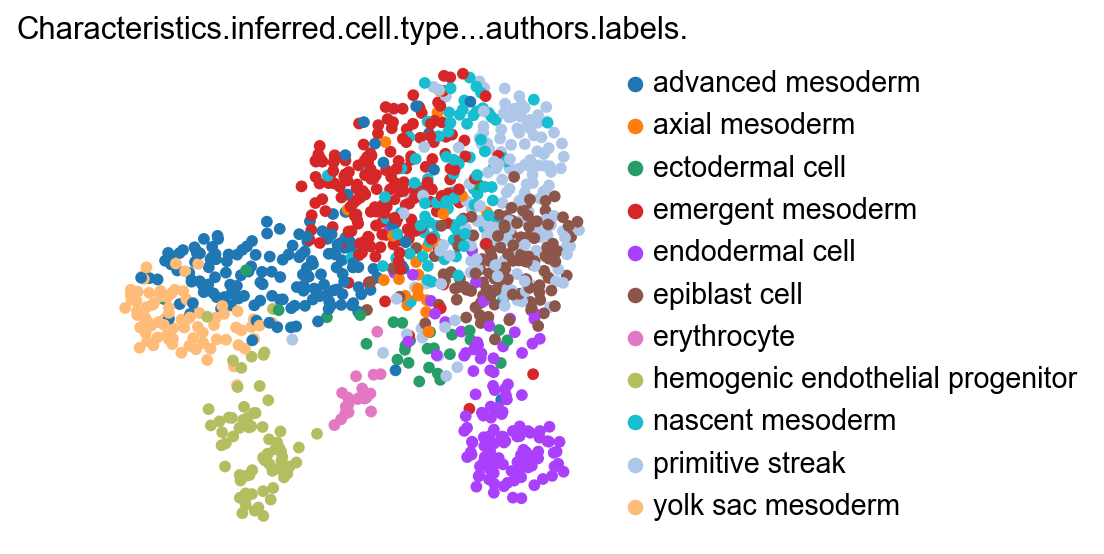

In [31]:
sc.pl.umap(adata, color=['Characteristics.inferred.cell.type...authors.labels.'], frameon=False)

In [32]:
hips.obs['batch'] = 'query'

In [33]:
hips.X = hips.X.astype(np.float32)


In [34]:
q_intr_cvae = sca.models.EXPIMAP.load_query_data(hips, intr_cvae)

AnnData object with n_obs × n_vars = 4694 × 1841
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'run', 'sample_name', 'percent.mt', 'percent.dissoc', 'RNA_snn_res.0.3', 'seurat_clusters', 'RNA_snn_res.0.22', 'batch'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_mnn', 'X_umap'
    obsp: 'distances'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1841 256 2
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 224
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  224 0 0 2 1841
	with hard mask.
Last Decoder layer: softmax


In [35]:
q_intr_cvae.train(n_epochs=400, alpha_epoch_anneal=100, weight_decay=0., alpha_kl=0.1, seed=2020, use_early_stopping=True)


Preparing (4694, 1841)
Instantiating dataset
 |███████████---------| 59.8%  - val_loss: 1130.1747436523 - val_recon_loss: 1124.5223999023 - val_kl_loss: 56.5234508514
ADJUSTED LR
 |████████████--------| 61.5%  - val_loss: 1128.0884094238 - val_recon_loss: 1122.4415283203 - val_kl_loss: 56.4688835144
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 245


In [45]:
q_intr_cvae.save('hippietippe_model')

In [36]:
dataset_samen = sc.AnnData.concatenate(adata, hips, batch_key='batch_join', uns_merge='same')
dataset_samen


AnnData object with n_obs × n_vars = 5763 × 1841
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Source.Name', 'Characteristics.sampling.site.', 'Characteristics.inferred.cell.type...authors.labels.', 'Characteristics.inferred.cell.type...ontology.labels.', 'cluster_id', 'sub_cluster', 'origin', 'run', 'sample_name', 'timepoint', 'percent.mt', 'batch', 'percent.dissoc', 'RNA_snn_res.0.3', 'seurat_clusters', 'RNA_snn_res.0.22', 'batch_join'
    var: 'features', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0'
    obsm: 'X_umap'

In [37]:
dataset_samen.X = dataset_samen.X.astype(np.float32)


In [38]:
dataset_samen.obsm['X_cvae'] = q_intr_cvae.get_latent(dataset_samen.X, dataset_samen.obs['batch'], mean=MEAN, only_active=True)

In [39]:
sc.pp.neighbors(dataset_samen, use_rep='X_cvae')

In [40]:
sc.tl.umap(dataset_samen)


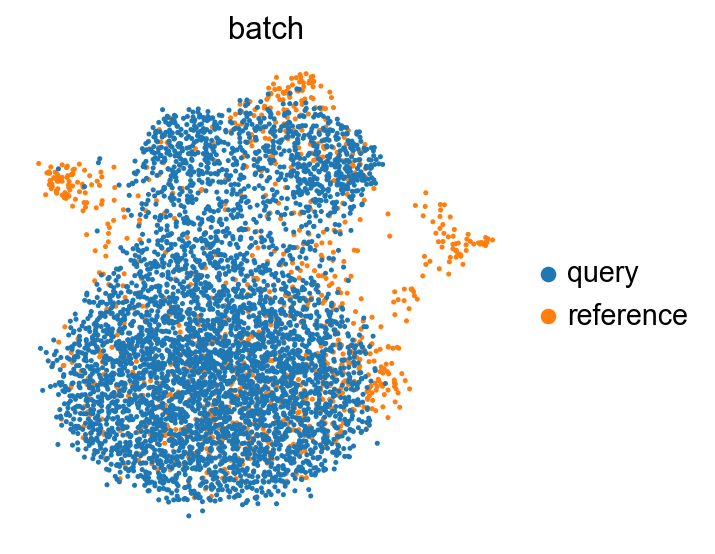

In [41]:
sc.pl.umap(dataset_samen, color=['batch'], frameon=False, wspace=0.6)


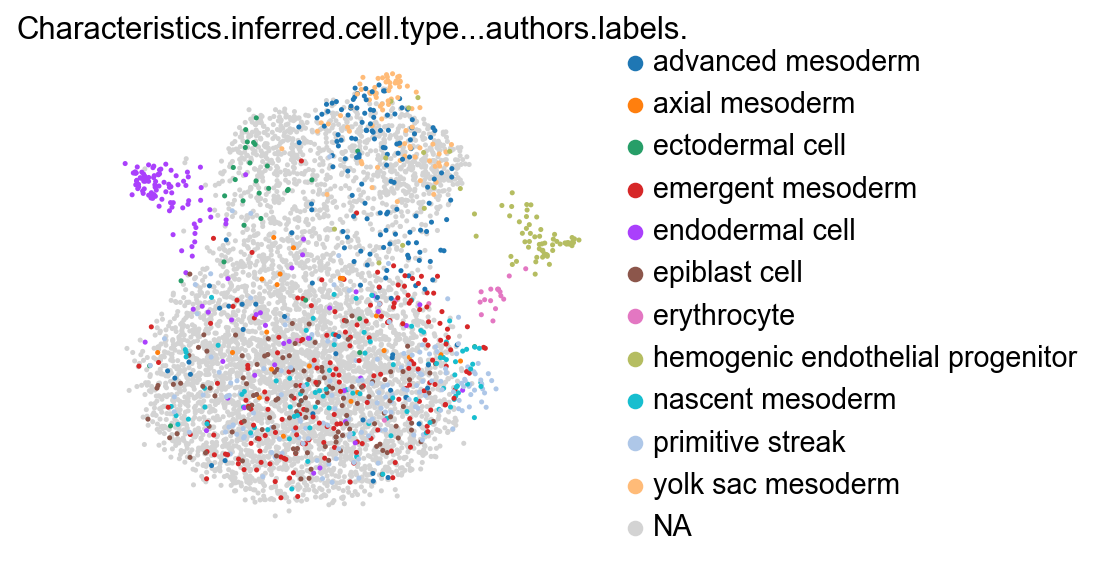

In [42]:
sc.pl.umap(dataset_samen, color=['Characteristics.inferred.cell.type...authors.labels.'], frameon=False, wspace=0.6)

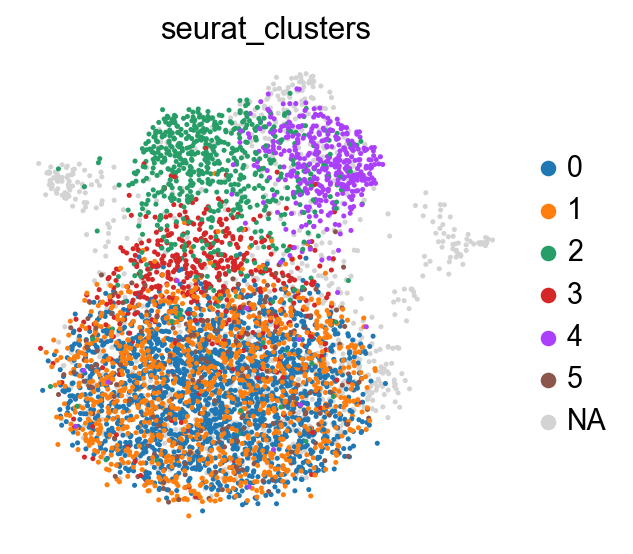

In [43]:

sc.pl.umap(dataset_samen, color=['seurat_clusters'], frameon=False, wspace=0.6)

In [44]:
dataset_samen.obs['orig.ident'] = dataset_samen.obs['orig.ident'].astype(str)


dataset_samen.write('hipstyser_integrated.h5ad')